# 14.0 Training on time-sequence data with an RNN
This is a draft example - not finished yet

In [1]:
# Mount GDrive, change directory and check contents of folder.

import os
import tensorflow as tf
from google.colab import drive
from google.colab import files

PROJECT_FOLDER = "/content/gdrive/My Drive/Colab Notebooks/CS345_SP22/14. RNN"

drive.mount('/content/gdrive/')
os.chdir(PROJECT_FOLDER)
print("Current dir: ", os.getcwd())

# What tensorflow version is installed in this VM?
print("Tensorflow version " + tf.__version__)
print("|__ GPUs Available: ", tf.config.list_physical_devices('GPU'))
print("|__ Default GPU Device:%s" % tf.test.gpu_device_name())

!pip install wfdb

Drive already mounted at /content/gdrive/; to attempt to forcibly remount, call drive.mount("/content/gdrive/", force_remount=True).
Current dir:  /content/gdrive/My Drive/Colab Notebooks/CS345_SP22/14. RNN
Tensorflow version 2.8.0
|__ GPUs Available:  [PhysicalDevice(name='/physical_device:GPU:0', device_type='GPU')]
|__ Default GPU Device:/device:GPU:0
Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


In [2]:
import os
import numpy as np
import tensorflow as tf
from tensorflow import keras
import matplotlib.pyplot as plt


from mllib.utils import RandomSeed
from models.RNN import CRNN

# __________ | Settings | __________
IS_PLOTING_DATA         = True
IS_DEBUGABLE            = False
IS_RETRAINING           = True
RandomSeed(2022)

Random seed set to 2022


# Hyperparameters


In [3]:
# __________ | Hyperparameters | __________
CONFIG_RNN = {
                 "ModelName": "RNN_SIGNAL"
                ,"ClassCount"                   : 20
                ,"LSTM.TimeStepInputShape"      : [49, 7]
                ,"LSTM.MaxInputLength"          : 50
                ,"LSTM.Units"                   : 50
                ,"LSTM.RecurrentDropOut"        : 0.2
                ,"LSTM.DropOut"                 : 0.2
                             
                ,"Training.MaxEpoch"    : 200
                ,"Training.BatchSize"   : 20
                ,"Training.LearningRate": 0.5
                ,"Training.LearningRateScheduling": [[50, 0.2], [100, 0.1]]
                ,"Training.Momentum": 0.9             
            }
                
CONFIG = CONFIG_RNN               

# Load Dataset
### Non-EEG Dataset for Assessment of Neurological Status from Physionet

In [4]:
from data.NeuroStatus import CNeuroStatus

# ... // Create the data objects \\ ...
oDataset = CNeuroStatus()
oDataset.SplitSequences(25)
print("-"*40, oDataset.Name, "-"*40)
  
print("%d sequences with %d clips, each one %d data points with %d features" % oDataset.Samples.shape)
print("%d labels for sequences" % oDataset.Labels.shape)

print("."*20, "Training Set", "."*40)
print("%d sequences with %d clips, each one %d data points with %d features" % oDataset.TSSamples.shape)
print("%d labels for sequences" % oDataset.TSLabels.shape)

print("."*20, "Validation Set", "."*40)
print("%d sequences with %d clips, each one %d data points with %d features" % oDataset.VSSamples.shape)
print("%d labels for sequences" % oDataset.VSLabels.shape)

20 total samples 
0 samples in the Training Set
0 samples in the Validation Set
20 total samples 
20 samples in the Training Set
20 samples in the Validation Set
---------------------------------------- NeuroStatusSignals ----------------------------------------
20 sequences with 75 clips, each one 49 data points with 7 features
20 labels for sequences
.................... Training Set ........................................
20 sequences with 50 clips, each one 49 data points with 7 features
20 labels for sequences
.................... Validation Set ........................................
20 sequences with 50 clips, each one 49 data points with 7 features
20 labels for sequences


# Data Feeding for Training and Validation
We create two data feeding objects that speed-up the loading of samples to the model's input. We use the `tf.data.Dataset` class and its method `from_tensor_slices()` to create the data feed object supplying as parameters the numpy arrays for the features of all TS samples `oDataset.TSSamples` and the corresponding class labels `oDataset.TSLabels`. We do the same for the VS.


In [5]:
# Creating one hot labels
nTSLabelsOnehot = keras.utils.to_categorical(oDataset.TSLabels, num_classes=CONFIG["ClassCount"])
nVSLabelsOnehot = keras.utils.to_categorical(oDataset.VSLabels, num_classes=CONFIG["ClassCount"])

print("TSSamples:", oDataset.TSSamples.shape)
print("VSSamples:", oDataset.VSSamples.shape)

nBatchSize = CONFIG["Training.BatchSize"] 
# Reshaping the feature matrix of eache time-step into a vector
nNewShape = list(oDataset.TSSamples.shape)
nFeatures = np.prod(nNewShape[-2:])
nNewShape = nNewShape[:-2] + [nFeatures]
oDataset.TSSamples = oDataset.TSSamples.reshape(nNewShape)
oDataset.VSSamples = oDataset.VSSamples.reshape(nNewShape)
print("TSSamples (reshaped):", oDataset.TSSamples.shape)
print("VSSamples (reshaped):", oDataset.VSSamples.shape)

# Creating the data feed objects
oTSData = tf.data.Dataset.from_tensor_slices((oDataset.TSSamples, nTSLabelsOnehot))
oTSData = oTSData.shuffle(nBatchSize).batch(nBatchSize, drop_remainder=True)

oVSData = tf.data.Dataset.from_tensor_slices((oDataset.VSSamples, nVSLabelsOnehot))
oVSData = oVSData.batch(oDataset.VSSampleCount, drop_remainder=True)

TSSamples: (20, 50, 49, 7)
VSSamples: (20, 50, 49, 7)
TSSamples (reshaped): (20, 50, 343)
VSSamples (reshaped): (20, 50, 343)


# RNN Model

In [6]:
import numpy as np
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras.layers import Embedding, Dense, LSTM, Softmax, Activation
from mllib.filestore import CFileStore
#from tensorflow.keras import regularizers

# =========================================================================================================================
class CRNN(keras.Model):
  # --------------------------------------------------------------------------------------
  def __init__(self, p_oConfig):
    super(CRNN, self).__init__()
    # ................................................................
    # // Attributes \\
    self.MaxInputLength     = p_oConfig["LSTM.MaxInputLength"]
    self.LSTMUnits          = p_oConfig["LSTM.Units"]
    self.RecurrentDropOut   = p_oConfig["LSTM.RecurrentDropOut"]
    self.DropOut            = p_oConfig["LSTM.DropOut"]
    self.ClassCount         = p_oConfig["ClassCount"]
    self.TimeStepInputShape = p_oConfig["LSTM.TimeStepInputShape"]
    self.TimeStepFeatures   = np.prod(self.TimeStepInputShape)

    
    self.Reshape      = None
    self.InputLayer   = None 
    self.LSTMLayer    = None
    self.OutputLayer  = None
    self.Softmax      = None
    # ................................................................
    self.CreateModel()
  # --------------------------------------------------------------------------------------
  def CreateModel(self):   
    #self.InputLayer = Dense(self.TimeStepFeatures)
    self.LSTMLayer  = LSTM(self.LSTMUnits, recurrent_dropout=self.RecurrentDropOut, dropout=self.DropOut)
    self.OutputLayer = Dense(self.ClassCount)
    self.Softmax    = Softmax()
  # --------------------------------------------------------------------------------------
  def call(self, p_tInput):
    tA = p_tInput
    #tA = self.InputLayer(tA)
    tA = self.LSTMLayer(tA)
    tA = self.OutputLayer(tA)
    tA = self.Softmax(tA) 
    
    return tA
# =========================================================================================================================                

# Create the Neural Network model and training algorithm objects



In [7]:
oNN = CRNN(CONFIG)

# -----------------------------------------------------------------------------------
def LRSchedule(epoch, lr):
    nNewLR = lr
    for nIndex,oSchedule in enumerate(CONFIG["Training.LearningRateScheduling"]):
        if epoch == oSchedule[0]:
            nNewLR = oSchedule[1]
            print("Schedule #%d: Setting LR to %.5f" % (nIndex+1,nNewLR))
            break
    return nNewLR
# -----------------------------------------------------------------------------------   

nInitialLearningRate    = CONFIG["Training.LearningRate"]  

oCostFunction   = tf.keras.losses.CategoricalCrossentropy(from_logits=False)
#oCostFunction   = tf.keras.losses.MeanSquaredError()
#oCostFunction   = keras.losses.BinaryCrossentropy()
#oMetrics = [keras.metrics.CategoricalAccuracy(name="average_accuracy", dtype=None)]
oMetrics = ["accuracy"] 
#oMetrics = [keras.metrics.BinaryAccuracy(name="average_accuracy", threshold=0.5, dtype=None)]


if "Training.LearningRateScheduling" in CONFIG:
  oOptimizer = tf.keras.optimizers.SGD(learning_rate=nInitialLearningRate, momentum=CONFIG["Training.Momentum"])
  oCallbacks = [tf.keras.callbacks.LearningRateScheduler(LRSchedule)]
else:
  oOptimizer = keras.optimizers.RMSprop(learning_rate=nInitialLearningRate)
  oCallbacks = None

#### Inspect the model architecture

In [8]:
# Compile the model for training
sModelFolderName = CONFIG["ModelName"]
        
bIsCompiledForTraining = False
if not os.path.isdir(sModelFolderName) or IS_RETRAINING:
    oNN.compile(loss=oCostFunction, optimizer=oOptimizer, metrics=["accuracy"])
    if IS_DEBUGABLE:
        oNN.run_eagerly = True    
    #oNN.predict(oVSData)
    #oNN.Structure.Print("Model-Structure-%s.csv" % CONFIG["ModelName"])
    bIsCompiledForTraining = True

### Train and evalute the model

In [9]:
if bIsCompiledForTraining:
    # Train the model
    oProcessLog = oNN.fit(  oTSData, batch_size=nBatchSize
                            ,epochs=CONFIG["Training.MaxEpoch"]
                            ,validation_data=oVSData
                            ,callbacks=oCallbacks
                          )
    oNN.summary()          
    oNN.save(sModelFolderName)      
else:
    # The model is trained and its state is saved (all the trainable parameters are saved). We load the model to recall the samples 
    oNN = keras.models.load_model(sModelFolderName)
    oProcessLog = None
    oNN.summary()    


Epoch 1/200
1/1 [==============================] - 4s 4s/step - loss: 3.0877 - accuracy: 0.0500 - val_loss: 3.1036 - val_accuracy: 0.0500 - lr: 0.5000
Epoch 2/200
1/1 [==============================] - 0s 110ms/step - loss: 3.1141 - accuracy: 0.0500 - val_loss: 3.0620 - val_accuracy: 0.0500 - lr: 0.5000
Epoch 3/200
1/1 [==============================] - 0s 103ms/step - loss: 3.1586 - accuracy: 0.0500 - val_loss: 3.1092 - val_accuracy: 0.0500 - lr: 0.5000
Epoch 4/200
1/1 [==============================] - 0s 110ms/step - loss: 3.1179 - accuracy: 0.0500 - val_loss: 3.0754 - val_accuracy: 0.0500 - lr: 0.5000
Epoch 5/200
1/1 [==============================] - 0s 114ms/step - loss: 3.0076 - accuracy: 0.1000 - val_loss: 3.1242 - val_accuracy: 0.0500 - lr: 0.5000
Epoch 6/200
1/1 [==============================] - 0s 105ms/step - loss: 3.1216 - accuracy: 0.1000 - val_loss: 3.0891 - val_accuracy: 0.0500 - lr: 0.5000
Epoch 7/200
1/1 [==============================] - 0s 99ms/step - loss: 3.0077 

# Learning Process Overview

Keys of Keras training process log: dict_keys(['loss', 'accuracy', 'val_loss', 'val_accuracy', 'lr'])


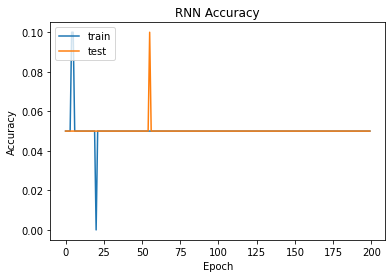

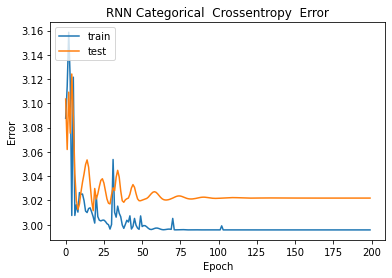

In [10]:
if oProcessLog is not None: # [PYTHON] Checks that object reference is not Null
    sModelPrefix = "RNN"
    # list all data in history
    print("Keys of Keras training process log:", oProcessLog.history.keys())
    
    # Plot the accuracy during the training epochs
    plt.plot(oProcessLog.history['accuracy'])
    plt.plot(oProcessLog.history['val_accuracy'])
    plt.title('%s Accuracy' % sModelPrefix)
    plt.ylabel('Accuracy')
    plt.xlabel('Epoch')
    plt.legend(['train', 'test'], loc='upper left')
    plt.show()
    
    # Plot the error during the training epochs
    sCostFunctionNameParts = oCostFunction.name.split("_")                           # [PYTHON]: Splitting string into an array of strings
    sCostFunctionNameParts = [x.capitalize() + " " for x in sCostFunctionNameParts]  # [PYTHON]: List comprehension example 
    sCostFunctionName = " ".join(sCostFunctionNameParts)                             # [PYTHON]: Joining string in a list with the space between them
    
    plt.plot(oProcessLog.history['loss'])
    plt.plot(oProcessLog.history['val_loss'])
    plt.title('%s %s' % (sModelPrefix, sCostFunctionName) + " Error")
    plt.ylabel('Error')
    plt.xlabel('Epoch')
    plt.legend(['train', 'test'], loc='upper left')
    plt.show()

# Inference / Evaluation

In [11]:
from mllib.evaluation import CEvaluator
from mllib.visualization import CPlotConfusionMatrix

nPredictedProbabilities = oNN.predict(oVSData)
nPredictedClassLabels  = np.argmax(nPredictedProbabilities, axis=1)



oEvaluator = CEvaluator(oData, nPredictedClassLabels)

oEvaluator.PrintConfusionMatrix()
print("Per Class Recall (Accuracy)  :", oEvaluator.Recall)
print("Per Class Precision          :", oEvaluator.Precision)
print("Average Accuracy: %.4f" % oEvaluator.AverageRecall)
print("Average F1 Score: %.4f" % oEvaluator.AverageF1Score)
      
oConfusionMatrixPlot = CPlotConfusionMatrix(oEvaluator.ConfusionMatrix)
oConfusionMatrixPlot.Show()      


NameError: ignored